# Predicting stock price movements based on news messages

## Business Understanding
* Target variables: classifying news articles in order to predict whether the closing price of the day is higher (1) or lower or equal than the opening price (0).
* Dataset: Data from https://www.kaggle.com/datasets/gennadiyr/us-equities-news-data?resource=download, which has already been preprocessed to remove punctuation
    * Scope: Apple stock (AAPL) relateed news 
* Key models:
    1. Data Processing: Bag of words (BOW)
    2. Data Reduction: Random Forest Classifier
    3. Prediction: Neural Networks

In [1]:
# Filtering by
tickerSymbol = "AAPL"
# Metric
chosen_metrics = ['Precision']
# Test size
size_test = 0.2
# For consistency
seed = 42
n_folds = 3
n_iter_search = 25
# Output folder
out_dir = 'model_output'

### Imports

In [2]:
import pandas as pd
pd.set_option('display.precision', 5)
import numpy as np
import scipy
from scipy.stats import randint, uniform
from functools import partial
import collections
from collections import defaultdict
import os
import re #regex
import pickle
import joblib
from tqdm import tqdm
import datetime
# Supporting dataset
import yfinance as yf
import holidays
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {'figure.figsize':(12,6), "axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Machine Learning imports
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer #,CountVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import precision_score, confusion_matrix
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical 
import keras_tuner as kt

import torch
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# NLTK imports
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt') # for the tokenizer
nltk.download('averaged_perceptron_tagger') # for POS
nltk.download('wordnet')
nltk.download('omw-1.4')

# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

D:\Users\camil\anaconda3\envs\pytorch_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data

## Data Understanding

In [3]:
# News data
#data1 = pd.read_csv('analyst_ratings_processed.csv', index_col=0)
#data1.dropna(inplace = True)
#data1.rename(columns={'stock':'ticker'}, inplace=True)
#data1['date'] = data1['date'].apply(lambda x : x.split()[0])
data_df = pd.read_csv('us_equities_news_dataset.csv', index_col=0)
data_df.dropna(inplace = True)
data_df.reset_index(drop=True, inplace=True)
data_df.rename(columns={'release_date':'date'}, inplace=True)
data_df.drop(inplace=True, columns=['category', 'url', 'article_id'], axis=1)

#data = pd.concat([data1, data2])
data = data_df
data.drop_duplicates(subset='title', keep='first', inplace=True)

# Filtering by ticker
data = data_df[data_df['ticker']==tickerSymbol]

In [4]:
# Looking at the data
print(data_df.info()) # Cleaned, with no null objects
start_date = data_df['date'].min()
end_date = data_df['date'].max()
print(f"\nMin date: {start_date}\nMax date: {end_date}")
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215439 entries, 0 to 221504
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ticker    215439 non-null  object
 1   title     215439 non-null  object
 2   content   215439 non-null  object
 3   date      215439 non-null  object
 4   provider  215439 non-null  object
dtypes: object(5)
memory usage: 9.9+ MB
None

Min date: 2008-10-02
Max date: 2020-02-13


,ticker,title,content,date,provider
0,NIO,Why Shares of Chinese Electric Car Maker NIO A...,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool
1,NIO,NIO only consumer gainer Workhorse Group amon...,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha
2,NIO,NIO leads consumer gainers Beyond Meat and Ma...,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha
3,NIO,NIO NVAX among premarket gainers,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha
4,NIO,PLUG NIO among premarket gainers,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha


In [5]:
# Which ticker has the most news?
frequency = collections.Counter(data_df['ticker'])
frequency = pd.DataFrame.from_dict(frequency, orient='index', columns = ['freq']).sort_values(by='freq', ascending=False).reset_index()

print(frequency.head(3))

  index   freq
0  AAPL  19985
1  MSFT   7877
2   BAC   7235


[*********************100%***********************]  1 of 1 completed


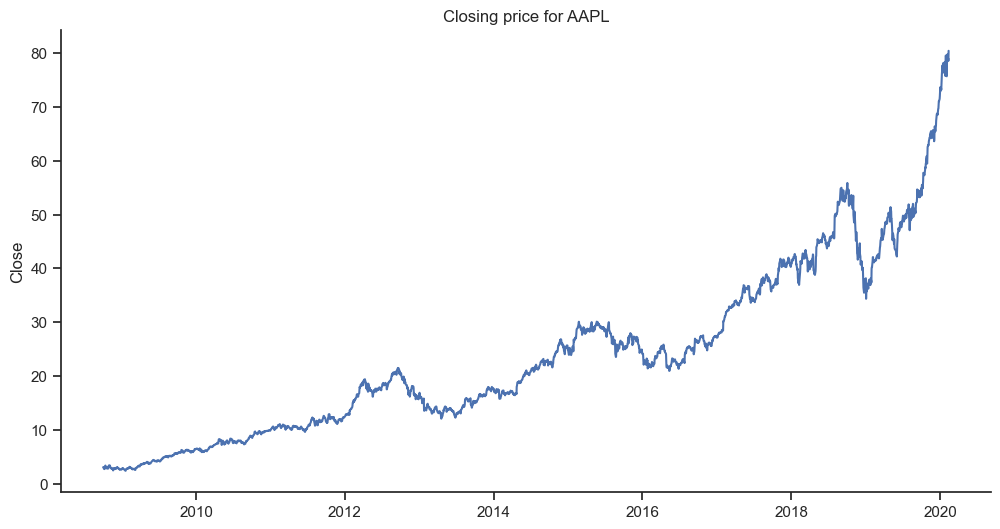

In [6]:
# Financial data
hist = yf.download(tickers = tickerSymbol,
                   start =  start_date,
                   end = end_date,
                   interval = "1d",
                   auto_adjust = True,
                   prepost = True,
                   threads = True,
                   proxy = None,
                  )

# Check for trends
fig = sns.lineplot(hist, x = [ i for i in hist.index], y = 'Close').set(title='Closing price for AAPL')

## Data Preparation

In [7]:
keep_list = ['no', 'not'] 
for word in keep_list:
    try:
        stop_words.remove(word)
    except:
        pass

# Checking if there are still words in the list:
#any(item in keep_list for item in stop_words)

def clean_text(text, normalize = True, remove_stopwords = True, stop_words = stop_words, 
               tokenizer = nltk.word_tokenize, lemmatizer = WordNetLemmatizer(), pos_tag = nltk.pos_tag):
    '''Return tokenized text, with the options:
    Normalization, Removal of unwanted characters, stopwords
    Attenttion: Lemmatizer needs tokenizer
    '''
    
    if normalize: # Convert words to lower case
        text = text.lower()
    
    # Tabs
    text = re.sub(r"[\n][\t]*|[\t]", " ", text) 
    # Puctuation
    #text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    # Numbers
    text = re.sub(r"[0-9]", "",text)
    # too long words: Incomprehensibilities is longest word “in common usage" or single letters
    text = re.sub(r"\b\w{25,90}\b|\b\w{1}\b", "",text)
    # Removing mentions (@person) and Hashtags #topic, 
    #text = re.sub(r"(@|#\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|^rt", "", text)
    # HTML
    #text = re.sub(r'(\<a href)|(<br />)', '', text)
    # Links: http://
    #text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)    
    # Extra space
    text = re.sub('\s+',' ',text)
       
    if remove_stopwords:
        text = " ".join([word for word in text.split() if word not in (stop_words)])
    
    # Tokenizer
    if tokenizer != False:
        tokens = tokenizer(text)
    
        if lemmatizer != False: # Lemmatization
            #text = " ".join([lemmatizer.lemmatize(word) for word in tokens])
            text = [lemmatizer.lemmatize(word) for word in tokens]
    
        #if pos_tag != False:
            #pos = pos_tag(tokens)
            #text = [text, pos]
        
    return text

#data.loc[:,'title'] = data['title'].apply(lambda x: clean_text(x, pos_tag = False))
data.loc[:,'title'] = data['title'].apply(lambda x: " ".join(clean_text(x, pos_tag = False)))

C:\Users\camil\AppData\Local\Temp\ipykernel_10120\2557729644.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'title'] = data['title'].apply(lambda x: " ".join(clean_text(x, pos_tag = False)))


In [8]:
tmpData = {}
total = data['date'].nunique()
for i in tqdm(data['date'].unique(), position=0, leave=True):
    tmpData[i] = data.loc[data['date'] == i]['title'].tolist()

100%|█████████████████████████████████████████████████████████████████████████████| 2261/2261 [00:03<00:00, 738.82it/s]


In [9]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()
def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

## Modelling

### Bag of words approach

In [10]:
# Making the Bag of Words (BOW)
bow = pd.DataFrame(columns=['date','title', 'Open', 'Close'])

for i in tqdm(tmpData, position=0, leave=True):
    start = i
    nextDay = next_business_day(start).strftime("%Y-%m-%d")
    try:
        prevDay = hist.loc[start]
        nextDay = hist.loc[nextDay]
        row = pd.DataFrame.from_dict({'date': [i], 'title':[' '.join(tmpData[i])], 'Open': nextDay['Open'], 'Close': nextDay['Close']})
        bow = pd.concat([bow, row])
    except:
        pass
    
y_class = bow.apply(lambda x: 1 if x['Close'] > x['Open'] else 0, axis = 1)
categories = y_class.unique()
categories.sort()

100%|████████████████████████████████████████████████████████████████████████████| 2261/2261 [00:01<00:00, 1217.72it/s]


In [11]:
# Is the dataset balanced?
frequency = collections.Counter(y_class)
frequency = pd.DataFrame.from_dict(frequency, orient='index', columns = ['freq']).sort_values(by='freq', ascending=False).reset_index()
print(frequency)
print(f"Percentage Difference of {200*(frequency.iloc[0]['freq']-frequency.iloc[1]['freq'])/(frequency.iloc[0]['freq']+frequency.iloc[1]['freq']):.2f}%")

   index  freq
0      1   900
1      0   830
Percentage Difference of 8.09%


In [12]:
vectorizer = TfidfVectorizer(lowercase=False, stop_words = 'english', ngram_range = (1, 2))# n-grams, min_df=2)

X_bow = vectorizer.fit_transform(np.array(bow['title'])).toarray()

#print(vectorizer.get_feature_names())
#print(vectorizer.vocabulary_)
#print(vectorizer.stop_words_) #for tfidf

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_bow, y_class)

clf = RandomForestClassifier(max_depth=2, random_state=seed)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f"Precision: {cross_val_score(clf, X_bow, y_class, cv=5, scoring=chosen_metrics[0].lower()).mean():.3f}")

Precision: 0.522


#### Dimensionality Reduction

In [14]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3,
                                 bootstrap=True, n_jobs=-1,
                                 random_state=seed)
rf.fit(X_bow, y_class)
feature_imp = pd.Series(rf.feature_importances_, 
                        index=vectorizer.get_feature_names()).sort_values(ascending=False)
print(f"Most important features: \n{feature_imp.head(15)}\n")

selector = SelectFromModel(rf)#, threshold=-np.inf, max_features=int(X_bow.shape[1]/100))
important_features = selector.fit_transform(X_bow, y_class)

bow_df = pd.DataFrame(X_bow, columns = vectorizer.get_feature_names_out())
feature_names = bow_df.columns[selector.get_support()]

print(f"Len before: {X_bow.shape[1]} Len after : {important_features.shape[1]}")

D:\Users\camil\anaconda3\envs\pytorch_venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Most important features: 
qcom                0.00879
nxp                 0.00747
outlook             0.00732
st                  0.00693
positioned slump    0.00690
file new            0.00685
app store           0.00661
break               0.00647
bullish             0.00639
google              0.00637
pressure            0.00636
future point        0.00583
proxy               0.00573
payment             0.00558
food                0.00549
dtype: float64

Len before: 85031 Len after : 405


#### Model Selection and Evaluation

In [15]:
X = important_features
#from sklearn.preprocessing import StandardScaler #Cannot be used as values cannot be <0
#scaler = StandardScaler()
scaler = MinMaxScaler(copy=False)
X = scaler.fit_transform(X)
y = y_class

In [16]:
# Define functions for evaluation metrics
##functools.partial(func, /, *args, **keywords)
##Return a new partial object which when called will behave like func called with the positional arguments args and keyword arguments keywords
## micro:Calculate metrics globally by counting the total true positives, false negatives and false positives
f1_micro = partial(metrics.f1_score, average='micro')
##'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
f1_macro = partial(metrics.f1_score, average='macro')
##'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall
f1_weighted = partial(metrics.f1_score, average='weighted')

##precision
precision_micro = partial(metrics.precision_score, average='micro')
precision_macro = partial(metrics.precision_score, average='macro')
precision_weighted = partial(metrics.precision_score, average='weighted')

##recall
recall_micro = partial(metrics.recall_score, average='micro')
recall_macro = partial(metrics.recall_score, average='macro')
recall_weighted = partial(metrics.recall_score, average='weighted')

def train_and_validate(pipe, X_train, y_train, X_test, y_test, test_metrics, scores, feature_names):
    '''
    Return trained pipeline and confusion matrix. Also populate test_metrics
    dictionary and scores dictionary.
    '''
    pipe.fit(X_train, y_train)
    ##predict_proba: Returns the probability of the samples for each class in the model. The columns correspond to the classes in sorted order, as they appear in the attribute classes_
    y_proba = pipe.predict_proba(X_test)
    ##numpy.argmax(a, axis=None, out=None): Returns the indices of the maximum values along an axis. Axis= is the highest for each column.
    y_pred = y_proba.argmax(axis=1)

    # Calculate confusion matrix on test set data
    confusion_mat = metrics.confusion_matrix(y_test, y_pred)

    for name, metric_fn in [
        #('accuracy', metrics.accuracy_score),
        #('kappa', metrics.cohen_kappa_score),
        #('f1_macro', f1_macro),
        #('f1_micro', f1_micro),
        #('f1_weighted', f1_weighted),
        ('precision_macro', precision_macro),
        ('precision_micro', precision_micro),
        ('precision_weighted', precision_weighted),
        #('recall_macro', recall_macro),
        #('recall_micro', recall_micro),
        #('recall_weighted', recall_weighted)
    ]:
        
        score = metric_fn(y_test, y_pred)
        test_metrics[name].append(score)
        
    # Calculate mean decrease in precision over 10 permutations
    decrease = metrics.precision_score(y_test, y_pred)
    np.random.seed(seed)
    for i in range(X.shape[1]):
        # shuffle 10 times
        for j in range(10):
            X_test_copy = X_test.copy()
            np.random.shuffle(X_test_copy[:, i])
            shuff_dec = metrics.precision_score( # Precision on the shuffled
                y_test,
                pipe.predict_proba(X_test_copy).argmax(axis=1))
            scores[feature_names[i]].append((decrease - shuff_dec) / decrease)

    return pipe, confusion_mat

In [17]:
# Define all classifiers and hyper-parameters
classifiers = [
    {
        'model': LogisticRegression(random_state=seed),
        'param_dist': {
            'class_weight': [None, 'balanced'],
            'fit_intercept': [True, False],
            'C': uniform(0, 1000),
            'solver': ['lbfgs'],
            'multi_class': ['ovr', 'multinomial'],
            'max_iter' : [10000],
        },
    },
    {#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        'model': RandomForestClassifier(random_state=seed), #n_jobs=-1
        'param_dist': {
            'n_estimators': randint(10, 200), 
            'criterion': ['gini', 'entropy'], #log_loss
            'min_samples_split': uniform(0.0, 1),
            'max_features': ['sqrt', 'log2', None],            
            'class_weight': ['balanced', 'balanced_subsample'],
        },
    },
    {#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
        'model': MLPClassifier(random_state=seed, early_stopping=True),
        'param_dist': {
            'hidden_layer_sizes': [(50,), (100,), (200,)],
            'alpha': uniform(0, 0.1),
            'activation': ['logistic', 'tanh', 'relu'],
            'solver': ['adam'],
            'batch_size': [32, 64, 128],
            'learning_rate': ['constant', 'adaptive'],
            'learning_rate_init': [0.0001],
            'max_iter': randint(200, 400),
        },
    },
    # {#https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    #     'model': LinearDiscriminantAnalysis(),
    #     'param_dist': {
    #         'solver': ['svd', 'eigen', 'lsqr'],
    #         #'n_components': randint(1, 5), #Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction. 
    #     },
    # },
    {#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
        'model': GaussianNB(),
        'param_dist': None, #var_smoothing float, default=1e-9
    },
    {
        'model': MultinomialNB(),
        'param_dist': {
            'fit_prior': [True, False],
            'alpha': uniform(0, 1),
        },
    },
    {
        'model': BernoulliNB(),
        'param_dist': {
            'fit_prior': [True, False],
            'alpha': uniform(0, 1),
        },
    },
    # {
    #     'model': KNeighborsClassifier(),
    #     'param_dist': {
    #         'n_neighbors': randint(1, 10),
    #         'weights': ['uniform', 'distance'],
    #         'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    #         'p': randint(1, 4),
    #     },
    # },
    {#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        'model': DecisionTreeClassifier(random_state=seed),
        'param_dist': {
            'criterion': ['gini', 'entropy'], #log_loss
            'splitter': ['best', 'random'],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': uniform(0.0, 1),
            'class_weight': ['balanced', None],
        },
    },
    # {#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    #     'model': SVC(probability=True, random_state=seed),
    #     'param_dist': {
    #         'C': uniform(0.001, 100),
    #         'gamma': uniform(0.001, 1000),
    #         'kernel': ['rbf', 'poly', 'sigmoid'],
    #         'degree': randint(1, 4),
    #         #'max_iter': randint(20, 200),
    #     },
    # },
    
    # {#from sklearn.neighbors import NearestCentroid
    #     'model': NearestCentroid(),
    #     'param_dist': {
    #         'metric': ['cityblock','cosine','euclidean','haversine','l1','l2','manhattan','nan_euclidean'], #sklearn.metrics.pairwise.distance_metrics()
    #         'shrink_threshold': [None, 0.1, 0.5, 0.7],
    #     },
    # },
]
    
def evaluate_models(X, y, feature_names = feature_names, out_dir = out_dir, classifiers = classifiers, size_test = 0.2, 
                    seed = 42, n_folds = 3, n_iter_search = 25, display = True):
    # Split into train/test sets. Training set = 90%
    ##stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.
    #Often, we want to preserve the dataset proportions for better prediction and reproduceability of results
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, random_state=seed)#,stratify=y)

    # Create dictionaries for storing models and results
    all_metrics = {}
    all_models = {}
    feature_importance = {}
    all_confusions = {}
    test_metrics = {}
    test_confusion = {}

    # Loop over all models
    for clf_dict in classifiers:
        clf = clf_dict['model']
        param_dist = clf_dict['param_dist']
        print("#" * 50)
        print(f"\nFitting: {clf}")

        # Use StratifiedKFold for k-fold data splitting when there are large class imbalances
        #folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

        if param_dist is not None:
            random_search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter_search,
                scoring = 'precision', #If None, the estimator’s score method is used              
                verbose=1,
                n_jobs=-1,
                #cv=folds, #Cross_fold
                #return_train_score=True,
                random_state=seed)

            # Do hyperparameter search
            random_search.fit(X_train, y_train)

            print("Best parameters:")
            print(random_search.best_params_)

            clf.set_params(**random_search.best_params_)

        test_metrics = defaultdict(list)
        models = []
        scores = defaultdict(list)
        confusion_mat = []

        # Train on all training data and get test performance
        ##The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
        ##For this, it enables setting parameters of the various steps using their names and the parameter name separated by a ‘__’,
        pipe = Pipeline(steps=[
            ('clf', clf),
        ])

        pipe, cm = train_and_validate(pipe, X_train, y_train, X_test, y_test, test_metrics, scores, feature_names)
        models.append(pipe)
        confusion_mat.append(cm)

        # Display evaluation metrics
        print("\nSummary on test set:")
        print(f"Model: {clf.__class__.__name__}")
        for metric in sorted(test_metrics.keys()):
            m = test_metrics[metric]
            print("{:<24}: {:.5f} ({:.5f})".format(
                metric,
                np.mean(m),
                np.std(m)))

        # Save model and evaluation metrics for later
        all_metrics[clf.__class__.__name__] = test_metrics
        all_models[clf.__class__.__name__] = models
        feature_importance[clf.__class__.__name__] = scores
        all_confusions[clf.__class__.__name__] = np.stack(confusion_mat)

        # Save model and evaluation metrics to disk
        dump = {
            'test_metrics': test_metrics,
            'models': models,
            'scores': scores,
        }
        joblib.dump(dump, '{}/{}_dump.pkl'.format(
            out_dir, clf.__class__.__name__))
        
    return all_metrics, all_models, feature_importance, all_confusions

all_metrics, all_models, feature_importance, all_confusions = evaluate_models(X, y)

##################################################

Fitting: LogisticRegression(random_state=42)
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters:
{'C': 207.9416628681888, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 10000, 'multi_class': 'ovr', 'solver': 'lbfgs'}

Summary on test set:
Model: LogisticRegression
precision_macro         : 0.56989 (0.00000)
precision_micro         : 0.56936 (0.00000)
precision_weighted      : 0.57163 (0.00000)
##################################################

Fitting: RandomForestClassifier(random_state=42)
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 0.5467102793432796, 'n_estimators': 63}

Summary on test set:
Model: RandomForestClassifier
precision_macro         : 0.56684 (0.00000)
precision_micro         : 0.56936 (0.00000)
precision_weighted      : 0.56804 (0.00

In [18]:
def write_metrics(all_metrics, out_dir):
    # Write metrics for all models out to csv
    df_metrics = {}

    for model in all_metrics:
        val_metrics = all_metrics[model]
        data = []
        index = []
        for metric in sorted(val_metrics.keys()):
            m = val_metrics[metric]
            data.append(np.mean(m))
            index.append(metric + "_mean")
            data.append(np.std(m))
            index.append(metric + "_std")

        df_metrics[model] = pd.Series(data, index=index)

    df_metrics = pd.DataFrame(df_metrics).transpose()
    df_metrics.to_csv("{}/results.csv".format(out_dir))
    return df_metrics

df_metrics = write_metrics(all_metrics, out_dir)

In [51]:
def write_confusion_matrix(all_confusions, out_dir = out_dir):
    # Write confusion matrices, precision, recall and f1 for all models out to csv
    for model in all_confusions:
        df_conf = pd.DataFrame(all_confusions[model].mean(axis=0))
        df_conf.columns = categories

        # Calculate class based precision/recall
        conf = df_conf.values
        recall = conf.diagonal() / conf.sum(axis=0)
        precision = conf.diagonal() / conf.sum(axis=1)
        f1 = 2 * (precision * recall) / (precision + recall)

        # Calculate Cohen's Kappa
        prob_mat = conf / conf.sum()
        row_sum = prob_mat.sum(axis=0)
        col_sum = prob_mat.sum(axis=1)

        kappa = ((
            prob_mat.diagonal() - row_sum * col_sum) /
            ((row_sum + col_sum) / 2 - row_sum * col_sum))

        df_conf['recall'] = pd.Series(recall, df_conf.index)
        df_conf['precision'] = pd.Series(precision, df_conf.index)
        df_conf['f1'] = pd.Series(f1, df_conf.index)
        df_conf['kappa'] = pd.Series(kappa, df_conf.index)

        df_conf.to_csv("{}/{}_confusion.csv".format(out_dir, model))
        
    return df_conf

df_conf = write_confusion_matrix(all_confusions, out_dir)

True

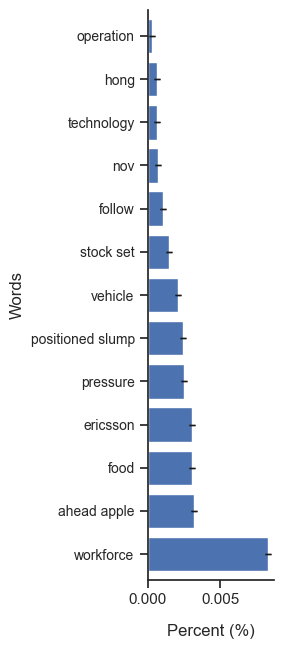

In [20]:
def plot_mean_decrease(feature_importance, out_dir):    
    # Plot and output to csv feature importances for all models
    for model in feature_importance:
        mean_decrease = []
        for k in feature_importance[model].keys():
            scores = feature_importance[model][k]
            mean_score = np.mean(scores)
            ##standard error of the mean
            sem_score = scipy.stats.sem(scores)
            if mean_score > 0:
                mean_decrease.append(
                    (k, mean_score, sem_score))

        #smt_ovs
        mean_decrease.sort(key=lambda x: x[1], reverse=True)

        # Plot feature importances and write to pdf
        names, scores, sems = zip(*mean_decrease[:30])

        plt.clf()
        plt.barh(range(len(names)), scores, yerr=sems, capsize=2)
        plt.yticks(
            range(len(names)),
            names,
            rotation='horizontal',
            fontsize=10)

        plt.xlabel("Percent (%)", fontsize=12, labelpad=12)
        plt.xlim(xmin=0)
        plt.ylabel("Words", fontsize=12)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.ylim((-0.6, len(names) - 0.4))
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        fig = plt.gcf()
        fig.set_size_inches(3,7)
        fig.savefig('{}/{}_mean_decrease.pdf'.format(out_dir, model), dpi=300)

        # Write feature importances to csv
        mda_series = pd.Series(scores, index=names)
        mda_series.to_csv('{}/{}_mean_decrease.csv'.format(out_dir, model))
        
    return True
        
plot_mean_decrease(feature_importance, out_dir)

#### Neural Network

In [41]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

def build_model(hp):
    model = keras.Sequential()
    model.add(normalizer)
    
    # Tune the number of layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid", "selu"]),
            )
        )
        
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(2, activation="softmax"))
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.Precision()],
    )
    
    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_precision", direction="max"),
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="model_output",
    project_name="kt_trials",
)

def build_tuned(tuner, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test)
    
    stop_early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    tuner.search(X_train, y_train, epochs=1000, validation_split=0.2, callbacks=[stop_early])
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]
    print(tuner.results_summary(1))
    
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=1000, batch_size=64, verbose=0, callbacks=[stop_early])
    val_metric_per_epoch = history.history[[i for i in history.history.keys()][3]]
    best_epoch = val_metric_per_epoch.index(max(val_metric_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}\n")

    # Rebuild the tuned model
    hypermodel = tuner.hypermodel.build(best_hps)
    # Retrain the model at best epoch
    hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2, verbose = 0)

    # Evaluate results
    print(hypermodel.evaluate(X_test, y_test, verbose=1))
    print(hypermodel.summary())
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    
    return hypermodel, history, cm

model_bow, history_bow, cm_bow = build_tuned(tuner, X, to_categorical(y))
model_bow.save('{}/{}.h5'.format(out_dir, 'model_bow'))

Trial 3 Complete [00h 01m 37s]
val_precision: 0.5974729359149933

Best val_precision So Far: 0.6064982116222382
Total elapsed time: 00h 05m 07s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in model_output\kt_trials
Showing 1 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 288
activation: selu
dropout: True
learning_rate: 0.00410133576488676
units_1: 384
units_2: 256
Score: 0.6064982116222382
None
Epoch 204: early stopping
Best epoch: 12

11/11 [==============================] - 0s 3ms/step - loss: 2.2567 - precision_2: 0.5925
[2.2567050457000732, 0.5924855470657349]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 405)              811       
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 288)

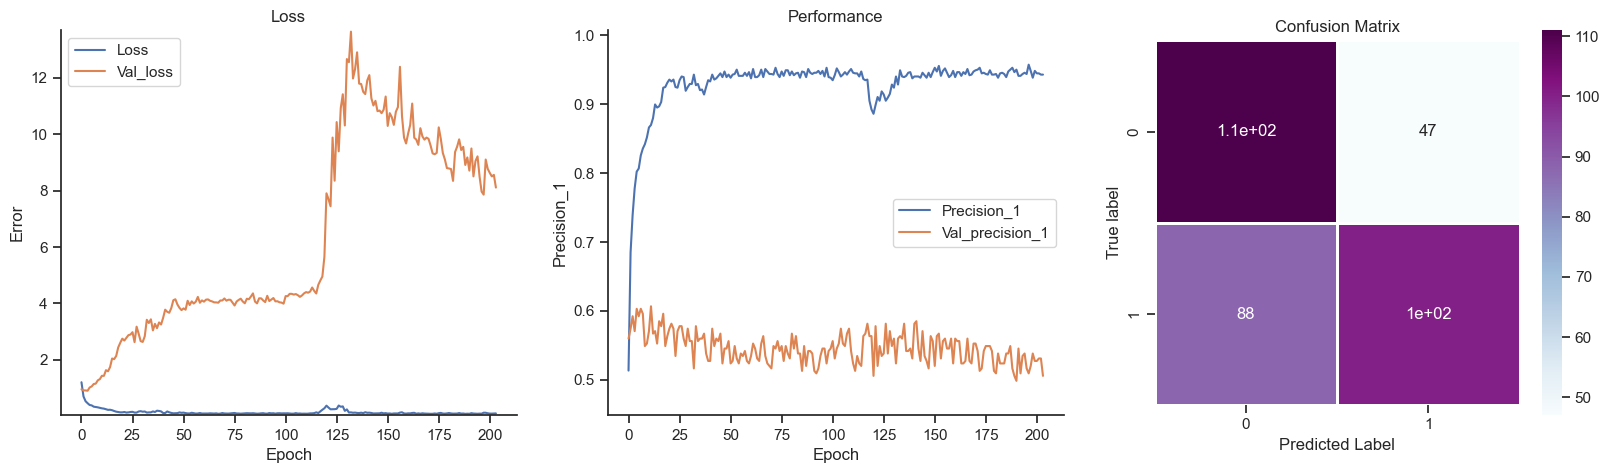

In [42]:
# Confusion Matrix
custom_params = {'figure.figsize':(20,5), "axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

def plot_evaluation(history, cm):
    offset = 0.05
    eval_metrics = [x for x in history.history.keys()]

    fig, ax = plt.subplots(1,3)
    # Loss
    sns.lineplot(history.history[eval_metrics[0]], label=eval_metrics[0].capitalize(), ax=ax[0])
    sns.lineplot(history.history[eval_metrics[2]], label=eval_metrics[2].capitalize(), ax=ax[0])
    ax[0].set(xlabel='Epoch', ylabel='Error')
    ax[0].set(title='Loss')
    ax[0].set(ylim=(min(min(history.history[eval_metrics[0]]), min(history.history[eval_metrics[2]]))-offset,
                    max(max(history.history[eval_metrics[0]]), max(history.history[eval_metrics[2]]))+offset))
    
    # Performance
    sns.lineplot(history.history[eval_metrics[1]], label=eval_metrics[1].capitalize(), ax=ax[1])
    sns.lineplot(history.history[eval_metrics[3]], label=eval_metrics[3].capitalize(), ax=ax[1])
    ax[1].set(xlabel='Epoch', ylabel=eval_metrics[1].capitalize())
    ax[1].set(title='Performance')
    ax[1].set(ylim=(min(min(history.history[eval_metrics[1]]), min(history.history[eval_metrics[3]]))-offset,
                    max(max(history.history[eval_metrics[1]]), max(history.history[eval_metrics[3]]))+offset))
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True,  cmap="BuPu", linewidths=1, square=True, ax=ax[2])
    ax[2].set(xlabel='Predicted Label', ylabel="True label")
    ax[2].set(title='Confusion Matrix')


    return fig
    
fig = plot_evaluation(history_bow, cm_bow)
fig.savefig('{}/{}.png'.format(out_dir, fig), dpi=fig.dpi)

### Sentiment analysis approach with FinBert
https://huggingface.co/ProsusAI/finbert

In [29]:
# Output folder
output_sem = 'model_output_sem'
if not os.path.exists(output_sem):
    os.makedirs(output_sem)

In [30]:
# FinBert sentiment analysis
def SentimentAnalyzer(doc):
    pt_batch = tokenizer(doc,padding=True,truncation=True,max_length=512,return_tensors="pt")
    outputs = finbert(**pt_batch)
    pt_predictions = F.softmax(outputs.logits, dim=-1)
    return pt_predictions.detach().cpu().numpy()

def findPercentageBySentences(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    sentimentArr = SentimentAnalyzer(sentenceList)
    sentimentArr = np.mean(sentimentArr, axis=0)
    posAvg=sentimentArr[0]
    negAvg=sentimentArr[1]
    neuAvg=sentimentArr[2]
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu' : neuAvg}

dateSentimentGroups = {}
for i in tqdm(tmpData, position=0, leave=True):
    scores = findPercentageBySentences(tmpData[i])
    dateSentimentGroups[i] = scores

# Grouping by Business date
sentiment_df = []
for i in tqdm(dateSentimentGroups, position=0, leave=True):
    start = i
    nextDay = next_business_day(start).strftime("%Y-%m-%d")
    try:
        prevDay = hist.loc[start]
        nextDay = hist.loc[nextDay]
        sentiment_df.append([dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg'], prevDay['Open'], prevDay['Close']])
    except:
        pass

sentiment_df = pd.DataFrame(columns =['numArticles', 'neutral', 'positive','negative', 'Open', 'Close'], data=sentiment_df)

100%|████████████████████████████████████████████████████████████████████████████| 2261/2261 [00:01<00:00, 1971.51it/s]


In [31]:
X = important_features
X = scaler.fit_transform(X)

#feature_names = bow_df.columns[selector.get_support()]
X_df = pd.DataFrame(X, columns = feature_names)
X_df = pd.concat([X_df, sentiment_df], axis=1)

feature_names = X_df.columns
X = pd.DataFrame.to_numpy(X_df)

#### Model Selection and Evaluation

In [32]:
all_metrics, all_models, feature_importance, all_confusions = evaluate_models(X, y, feature_names = feature_names)

##################################################

Fitting: LogisticRegression(C=207.9416628681888, class_weight='balanced',
                   fit_intercept=False, max_iter=10000, multi_class='ovr',
                   random_state=42)
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters:
{'C': 122.03823484477883, 'class_weight': None, 'fit_intercept': False, 'max_iter': 10000, 'multi_class': 'ovr', 'solver': 'lbfgs'}

Summary on test set:
Model: LogisticRegression
precision_macro         : 0.56939 (0.00000)
precision_micro         : 0.57225 (0.00000)
precision_weighted      : 0.57042 (0.00000)
##################################################

Fitting: RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_features='log2',
                       min_samples_split=0.5467102793432796, n_estimators=63,
                       random_state=42)
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best par

True

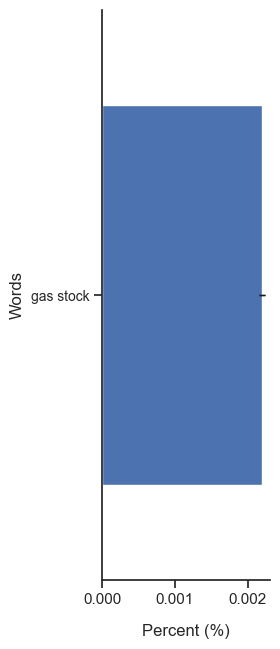

In [47]:
df_metrics = write_metrics(all_metrics, output_sem)
df_conf = write_confusion_matrix(all_confusions, output_sem)
plot_mean_decrease(feature_importance, output_sem)

In [34]:
# With LazyClassifier AutoML
#from lazypredict.Supervised import LazyClassifier
#clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=precision_score)
#models, predictions = clf.fit(X_train, X_test, y_train, y_test)
#models

#### Neural Network

Trial 3 Complete [00h 01m 34s]
val_precision: 0.6046931445598602

Best val_precision So Far: 0.6263537704944611
Total elapsed time: 00h 07m 08s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in model_output\kt_trials
Showing 1 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 352
activation: sigmoid
dropout: True
learning_rate: 0.0048033592616410145
units_1: 480
units_2: 96
Score: 0.6263537704944611
None
Epoch 202: early stopping
Best epoch: 26

11/11 [==============================] - 0s 3ms/step - loss: 2.6036 - precision_2: 0.5723
[2.6036264896392822, 0.5722543597221375]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 411)              823       
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 

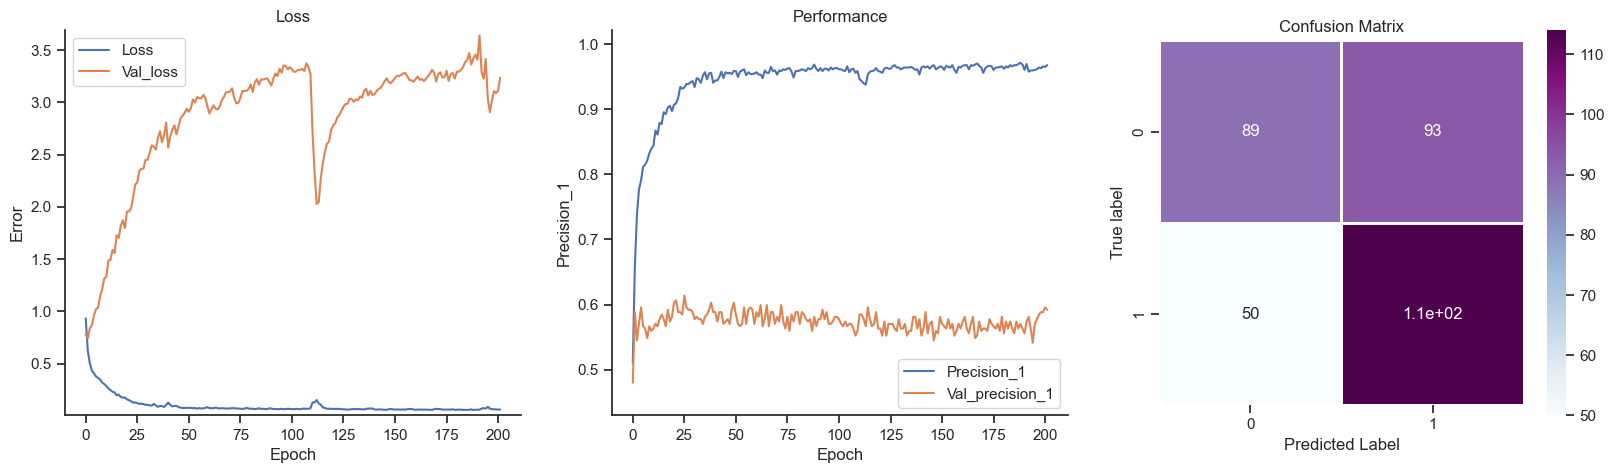

In [39]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

model_sent, history_sent, cm_sent = build_tuned(tuner, X, to_categorical(y))
model_sent.save('{}/{}.h5'.format(out_dir, 'model_sent'))
fig_sent = plot_evaluation(history_sent, cm_sent)
fig_sent.savefig('{}/{}.png'.format(out_dir, 'fig_sent'))

## Deployment and Recommendations
* The best performing model and the one that should be deployed was the following pipeline:
1. Text data preprocessing:
Lowercase all words
Stopword removal (for english)
Remove Unicode characters
Removing numbers, since we are focused on the effect that the words in the news have on the Stock market 
Removal of too long words over 25 characters (since these might be a typo or outlier) or single letters
Removal of repeated spaces
Contradiction equalization
Lemmatization 
2. Feature extraction with TfidfVectorizer 
3. Classification with GaussianNB

In practicality paying attention when key words appear in the news such as qcom	nxp	outlook	st	positioned slump	file new	app store	break	bullish	google	pressure	future point	proxy	payment	food


In [36]:
#How to unpickle
#joblib.load('BernoulliNB_dump.pkl')